In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

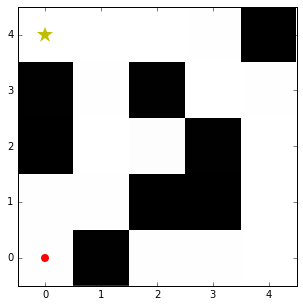

In [2]:
from environment import MazeEnv
mx = 5
my = 5
np.random.seed(8)
# TODO: Calculate max_reward_treasure dependend on metric for complexity of the maze, eg mx*my or distance of treasure
env = MazeEnv(mx, my, max_reward_treasure=1000., reward_wall=0., observation_type='image')
env.reset()
env.render()

This is what the neural network sees:


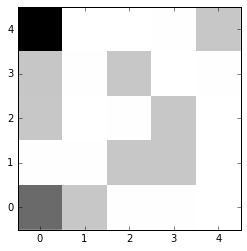

In [3]:
print 'This is what the neural network sees:'
plt.imshow(env.reset().T, interpolation='None', origin='lower', cmap='Greys')

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(20, input_dim=mx*my, activation='relu'))  # TODO: Use input as 2d array.
model.add(Dense(20, activation='relu'))  # TODO: Use input as 2d array.
model.add(Dense(4))
model.compile(SGD(lr=0.004), 'mse')

Using Theano backend.
D:\Python\27_32bit\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
# epsilon = 0.2  # probability to choose random action instead of best action
gamma = 0.95
batch_size = 150
# memory_size = 1000
max_num_steps = 400

In [6]:
memory = []
memory_lens = []
history = []
loss = []
total_rewards = []
heatmap = np.zeros((mx, my))

In [7]:
verbose = False

num_epochs = 100
for epoch, epsilon, memory_size in zip(range(num_epochs), np.linspace(1., 0.05, num_epochs), np.linspace(5000, 1000, num_epochs)):    
    state = env.reset()
    done = False
    loss_epoch = []
    rewards_epoch = []
    time = 0
    
    while not done and time < max_num_steps:
        time += 1
        
        if np.random.rand() <= epsilon:
            action = np.random.randint(4)
            if verbose: print 'choosing random action {} ({}),'.format(action, env.action_to_label[action]),
        else:
            Q = model.predict(state.reshape(1, -1))
            action = np.argmax(Q)
            if verbose: print 'choosing best action {} ({}),'.format(action, env.action_to_label[action]),

        new_state, reward, done, info = env.step(action)
        if verbose: print 'reward {}'.format(reward)
            
        memory.append([state, action, reward, new_state, done])
        while len(memory) > memory_size:  # only keep the most recent experiences in memory
            del memory[0]
        
        # Replay memories and train network.
        actual_batch_size = min(batch_size, len(memory))
        inputs = np.zeros((actual_batch_size, mx * my))
        targets = np.zeros((actual_batch_size, 4))
 
        # TODO: Maybe train multiple batches at once.
        for i, j in enumerate(np.random.choice(len(memory), size=actual_batch_size, replace=False)):
            s, a, r, new_s, d = memory[j]
            inputs[i] = s.flatten()
            Q = model.predict(s.reshape(1, -1))[0]
            targets[i] = Q
            if done:
                targets[i, a] = r
            else:
                Q_new = model.predict(new_s.reshape(1, -1))[0]
                targets[i, a] = r + gamma * np.max(Q_new)

        loss_epoch.append(model.train_on_batch(inputs, targets)[0])
        rewards_epoch.append(reward)
        
        state = new_state    
        heatmap[info['player_position']] += 1
        
    history.append(info['time'])
    print 'Epoch {} - loss {} - {} {} steps - final reward {} - total reward {}'.format(epoch, np.mean(loss_epoch), 'solved in' if done else 'aborted after', time, reward, np.sum(rewards_epoch))
    loss.append(np.mean(loss_epoch))
    total_rewards.append(np.sum(rewards_epoch))
    memory_lens.append(len(memory))
    
    if verbose: print 'Finished in {} steps'.format(info['time'])
    if verbose: print

Epoch 0 - loss 0.99112612009 - solved in 23 steps - final reward 43.4782608696 - total reward 43.4782608696
Epoch 1 - loss 10.4784126282 - solved in 57 steps - final reward 17.5438596491 - total reward 17.5438596491
Epoch 2 - loss 4.63638114929 - solved in 90 steps - final reward 11.1111111111 - total reward 11.1111111111
Epoch 3 - loss 2.84004354477 - solved in 75 steps - final reward 13.3333333333 - total reward 13.3333333333
Epoch 4 - loss 2.20874905586 - solved in 139 steps - final reward 7.19424460432 - total reward 7.19424460432
Epoch 5 - loss 1.43972611427 - solved in 67 steps - final reward 14.9253731343 - total reward 14.9253731343
Epoch 6 - loss 1.76654088497 - solved in 37 steps - final reward 27.027027027 - total reward 27.027027027
Epoch 7 - loss 1.86829471588 - solved in 171 steps - final reward 5.84795321637 - total reward 5.84795321637
Epoch 8 - loss 3.13505673409 - solved in 26 steps - final reward 38.4615384615 - total reward 38.4615384615
Epoch 9 - loss 1.77178430557

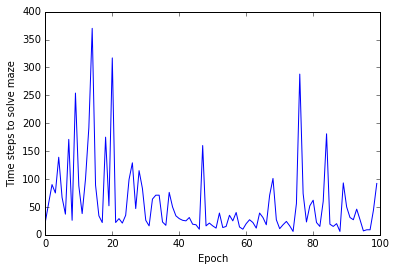

In [8]:
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Time steps to solve maze')
#plt.ylim(0, 10000)

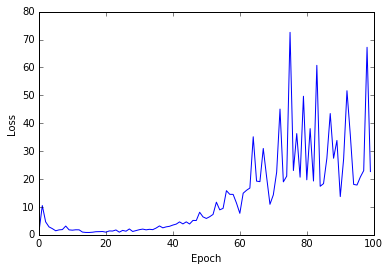

In [9]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

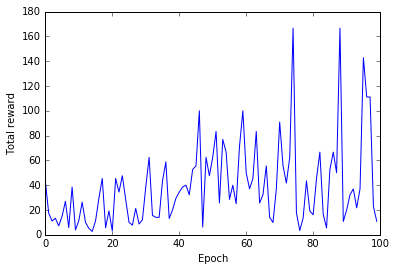

In [10]:
plt.plot(total_rewards)
plt.xlabel('Epoch')
plt.ylabel('Total reward')

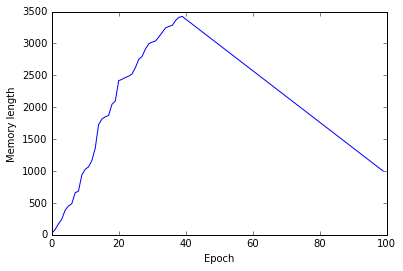

In [11]:
plt.plot(memory_lens)
plt.xlabel('Epoch')
plt.ylabel('Memory length')

(-0.5, 4.5)

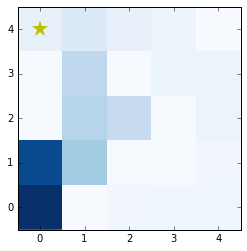

In [141]:
plt.imshow(heatmap.T, interpolation='none', origin='lower', cmap='Blues')
plt.plot(env.treasure[0], env.treasure[1], 'y*', mec='none', markersize=17)  # TODO: Maybe do not get treasure variable directly.
plt.xlim(-0.5, mx - 0.5)
plt.ylim(-0.5, my - 0.5)

In [ ]:
# Plot arrows for each direction, where the arrow width represents the Q value.
env.reset()
env.render()
arrow_length = 0.2
c = 'k'
width_factor = 0.001 / np.max(Q)
for x in range(mx):
    for y in range(my):
        plt.arrow(x, y, 0., arrow_length, ec=c, fc=c, width=width_factor*Q[state_index((x, y)), 0])  # up
        plt.arrow(x, y, 0., -arrow_length, ec=c, fc=c, width=width_factor*Q[state_index((x, y)), 1])  # down
        plt.arrow(x, y, -arrow_length, 0., ec=c, fc=c, width=width_factor*Q[state_index((x, y)), 2])  # left
        plt.arrow(x, y, arrow_length, 0., ec=c, fc=c, width=width_factor*Q[state_index((x, y)), 3])  # right

In [ ]:
# Plot arrow for the direction with the highest Q value.
env.reset()
env.render()
l = 0.3
c = 'k'
w = 0.01
for x in range(mx):
    for y in range(my):
        best_action = np.argmax(Q[state_index((x, y))])
        if best_action == 0:            
            plt.arrow(x, y-0.5*l, 0, l, ec=c, fc=c, width=w)  # up
        elif best_action == 1:
            plt.arrow(x, y+0.5*l, 0., -l, ec=c, fc=c, width=w)  # down
        elif best_action == 2:
            plt.arrow(x+0.5*l, y, -l, 0., ec=c, fc=c, width=w)  # left
        elif best_action == 3:
            plt.arrow(x-0.5*l, y, l, 0., ec=c, fc=c, width=w)  # right

choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing random action 1 (down), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing best action 3 (right), reward 0.0
choosing r

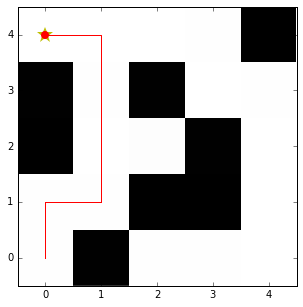

In [142]:
# Single run.
verbose = True
epsilon = 0.1#1 #0.05

state = env.reset()
done = False

Q_history = []

while not done and time < max_num_steps:
#     if verbose: print 'State {} (index {}),'.format(state, state_index(state)),
        
    if np.random.rand() <= epsilon:
        action = np.random.randint(4)
        if verbose: print 'choosing random action {} ({}),'.format(action, env.action_to_label[action]),
    else:
        Q = model.predict(state.reshape(1, -1))[0]
        Q_history.append(Q)
        action = np.argmax(Q)
        if verbose: print 'choosing best action {} ({}),'.format(action, env.action_to_label[action]),

    new_state, reward, done, info = env.step(action)
    if verbose: print 'reward {}'.format(reward)

    state = new_state
    
print 'Finished in {} steps'.format(info['time'])
    
env.render()

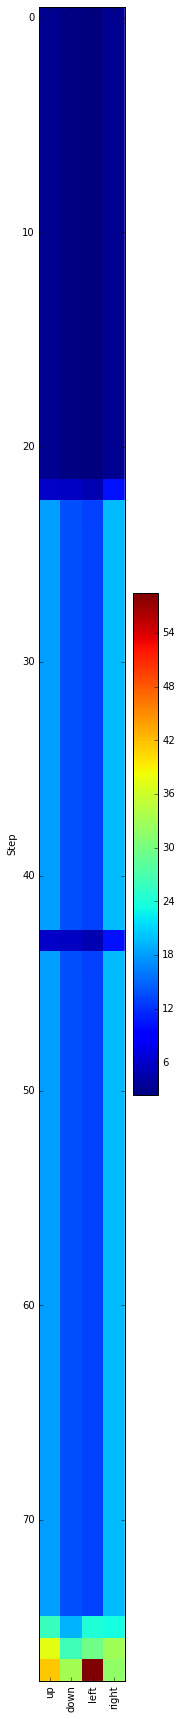

In [143]:
plt.figure(figsize=(3, 30))
plt.imshow(Q_history, interpolation='none')
plt.xticks(env.action_to_label.keys(), env.action_to_label.values(), rotation='vertical')
plt.colorbar()
plt.ylabel('Step')